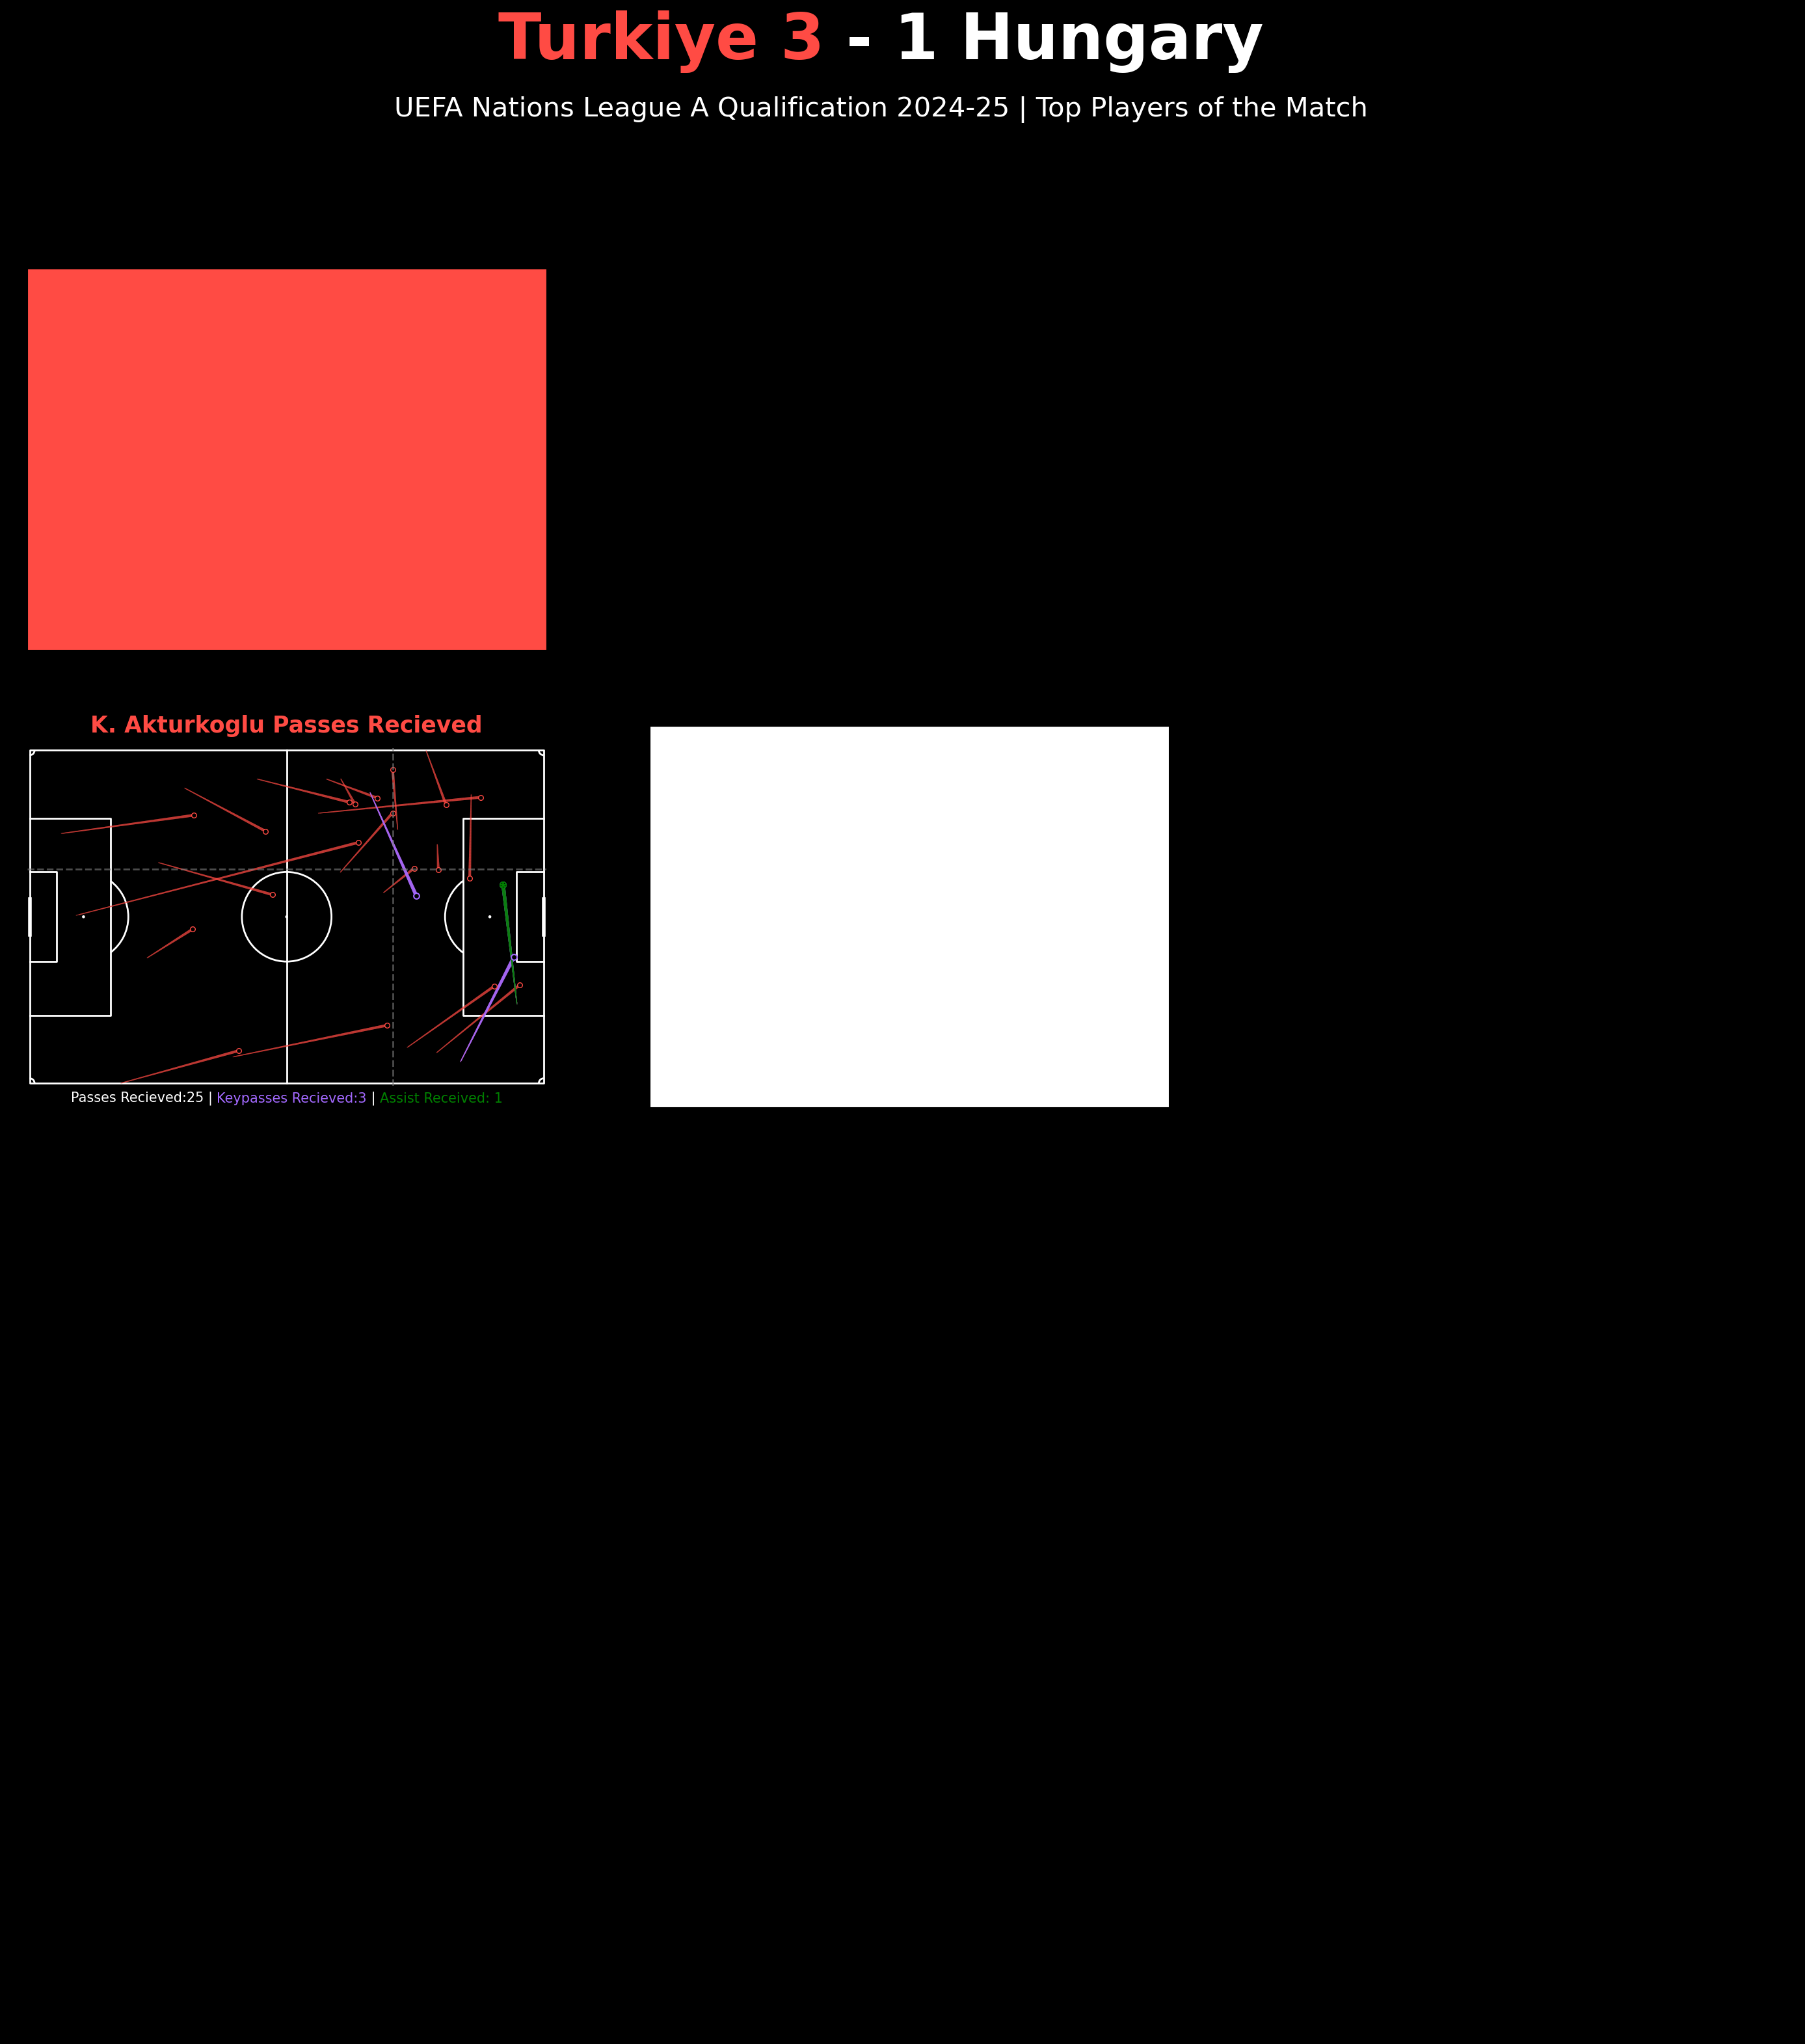

In [41]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from pprint import pprint
import matplotlib.image as mpimg
import matplotlib.patches as patches
from io import BytesIO
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle
from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen, add_image
from matplotlib.font_manager import FontProperties
from matplotlib import rcParams
from matplotlib.patheffects import withStroke, Normal
from matplotlib.colors import LinearSegmentedColormap
from mplsoccer.utils import FontManager
import matplotlib.patheffects as path_effects
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from sklearn.cluster import KMeans
import warnings
from highlight_text import ax_text, fig_text
from PIL import Image
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
from scipy.spatial import ConvexHull

# Print the modified DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

fig, axs = plt.subplots(4, 3, figsize=(35, 35), facecolor="black")

for ax in axs.flatten():
    ax.set_facecolor("black")  # Set all plots black initially

# Set one section red and another white
axs[0, 0].set_facecolor("#ff4b44")  # Red background for one section
axs[1, 1].set_facecolor("#ffffff")  # White background for another section

# Update colors
bg_color = "#000000"
line_color = "#ffffff"
red = "#ff4b44"
white = "#ffffff"

# Title with highlights
fig_text(
    0.5, 0.98, f"<{hteamName} {hgoal_count}> - <{agoal_count} {ateamName}>",
    color="white", fontsize=70, fontweight="bold",
    highlight_textprops=[{"color": red}, {"color": white}],
    ha="center", va="center", ax=fig
)

fig.text(0.5, 0.95, "UEFA Nations League A Qualification 2024-25 | Top Players of the Match",
         color="white", fontsize=30, ha="center", va="center")

# Set pitch with black background
pitch = Pitch(pitch_type="uefa", pitch_color="black", line_color="white", linewidth=2, corner_arcs=True)

# Example plot
home_passes_recieved(axs[1, 0])  # This plot will now have a black background

plt.show()

In [42]:
# Put the match HTML file path here
match_html_path = './Turkiye 3-1 Hungary - UEFA Nations League A Qualification 2024:2025 Live.html'
# Put the Fotmob matchId here
fotmob_matchId =4679425

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict


json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)

# Put a random empty directory path here just to keep the data there and read again, I found this necessary for me, for you it may not be needed.
df.to_csv("D:\FData\RawData\EventData.csv")
df = pd.read_csv("D:\FData\RawData\EventData.csv")
dfp.to_csv("D:\FData\RawData\PlayerData.csv")
dfp = pd.read_csv("D:\FData\RawData\PlayerData.csv")

# Extract the 'displayName' value
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

# temprary use of typeId of period column
df['period'] = df['period'].replace({'FirstHalf': 1, 'SecondHalf': 2, 'FirstPeriodOfExtraTime': 3, 'SecondPeriodOfExtraTime': 4, 
                                     'PenaltyShootout': 5, 'PostGame': 14, 'PreMatch': 16})

# new column for cumulative minutes, This part is taken from the "jakeyk11.github.io" github repository and modified for my use
def cumulative_match_mins(events_df):
    events_out = pd.DataFrame()
    # Add cumulative time to events data, resetting for each unique match
    match_events = events_df.copy()
    match_events['cumulative_mins'] = match_events['minute'] + (1/60) * match_events['second']
    # Add time increment to cumulative minutes based on period of game.
    for period in np.arange(1, match_events['period'].max() + 1, 1):
        if period > 1:
            t_delta = match_events[match_events['period'] == period - 1]['cumulative_mins'].max() - \
                                   match_events[match_events['period'] == period]['cumulative_mins'].min()
        elif period == 1 or period == 5:
            t_delta = 0
        else:
            t_delta = 0
        match_events.loc[match_events['period'] == period, 'cumulative_mins'] += t_delta
    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events])
    return events_out

df = cumulative_match_mins(df)

# Extracting the carry data and merge it with the main df, This part is also taken from the "jakeyk11.github.io" github repository and modified for my use
def insert_ball_carries(events_df, min_carry_length=3, max_carry_length=60, min_carry_duration=1, max_carry_duration=10):
    events_out = pd.DataFrame()
    # Carry conditions (convert from metres to opta)
    min_carry_length = 3.0
    max_carry_length = 60.0
    min_carry_duration = 1.0
    max_carry_duration = 10.0
    # match_events = events_df[events_df['match_id'] == match_id].reset_index()
    match_events = events_df.reset_index()
    match_carries = pd.DataFrame()
    
    for idx, match_event in match_events.iterrows():

        if idx < len(match_events) - 1:
            prev_evt_team = match_event['teamId']
            next_evt_idx = idx + 1
            init_next_evt = match_events.loc[next_evt_idx]
            take_ons = 0
            incorrect_next_evt = True

            while incorrect_next_evt:

                next_evt = match_events.loc[next_evt_idx]

                if next_evt['type'] == 'TakeOn' and next_evt['outcomeType'] == 'Successful':
                    take_ons += 1
                    incorrect_next_evt = True

                elif ((next_evt['type'] == 'TakeOn' and next_evt['outcomeType'] == 'Unsuccessful')
                      or (next_evt['teamId'] != prev_evt_team and next_evt['type'] == 'Challenge' and next_evt['outcomeType'] == 'Unsuccessful')
                      or (next_evt['type'] == 'Foul')):
                    incorrect_next_evt = True

                else:
                    incorrect_next_evt = False

                next_evt_idx += 1

            # Apply some conditioning to determine whether carry criteria is satisfied
            same_team = prev_evt_team == next_evt['teamId']
            not_ball_touch = match_event['type'] != 'BallTouch'
            dx = 105*(match_event['endX'] - next_evt['x'])/100
            dy = 68*(match_event['endY'] - next_evt['y'])/100
            far_enough = dx ** 2 + dy ** 2 >= min_carry_length ** 2
            not_too_far = dx ** 2 + dy ** 2 <= max_carry_length ** 2
            dt = 60 * (next_evt['cumulative_mins'] - match_event['cumulative_mins'])
            min_time = dt >= min_carry_duration
            same_phase = dt < max_carry_duration
            same_period = match_event['period'] == next_evt['period']

            valid_carry = same_team & not_ball_touch & far_enough & not_too_far & min_time & same_phase &same_period

            if valid_carry:
                carry = pd.DataFrame()
                prev = match_event
                nex = next_evt

                carry.loc[0, 'eventId'] = prev['eventId'] + 0.5
                carry['minute'] = np.floor(((init_next_evt['minute'] * 60 + init_next_evt['second']) + (
                        prev['minute'] * 60 + prev['second'])) / (2 * 60))
                carry['second'] = (((init_next_evt['minute'] * 60 + init_next_evt['second']) +
                                    (prev['minute'] * 60 + prev['second'])) / 2) - (carry['minute'] * 60)
                carry['teamId'] = nex['teamId']
                carry['x'] = prev['endX']
                carry['y'] = prev['endY']
                carry['expandedMinute'] = np.floor(((init_next_evt['expandedMinute'] * 60 + init_next_evt['second']) +
                                                    (prev['expandedMinute'] * 60 + prev['second'])) / (2 * 60))
                carry['period'] = nex['period']
                carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
                carry['outcomeType'] = 'Successful'
                carry['qualifiers'] = carry.apply(lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
                carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
                carry['isTouch'] = True
                carry['playerId'] = nex['playerId']
                carry['endX'] = nex['x']
                carry['endY'] = nex['y']
                carry['blockedX'] = np.nan
                carry['blockedY'] = np.nan
                carry['goalMouthZ'] = np.nan
                carry['goalMouthY'] = np.nan
                carry['isShot'] = np.nan
                carry['relatedEventId'] = nex['eventId']
                carry['relatedPlayerId'] = np.nan
                carry['isGoal'] = np.nan
                carry['cardType'] = np.nan
                carry['isOwnGoal'] = np.nan
                carry['type'] = 'Carry'
                carry['cumulative_mins'] = (prev['cumulative_mins'] + init_next_evt['cumulative_mins']) / 2

                match_carries = pd.concat([match_carries, carry], ignore_index=True, sort=False)

    match_events_and_carries = pd.concat([match_carries, match_events], ignore_index=True, sort=False)
    match_events_and_carries = match_events_and_carries.sort_values(['period', 'cumulative_mins']).reset_index(drop=True)

    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events_and_carries])

    return events_out

df = insert_ball_carries(df, min_carry_length=3, max_carry_length=60, min_carry_duration=1, max_carry_duration=10)

df = df.reset_index(drop=True)
df['index'] = range(1, len(df) + 1)
df = df[['index'] + [col for col in df.columns if col != 'index']]

# Assign xT values
df_base  = df
dfxT = df_base.copy()
dfxT['qualifiers'] = dfxT['qualifiers'].astype(str)
dfxT = dfxT[(~dfxT['qualifiers'].str.contains('Corner'))]
dfxT = dfxT[(dfxT['type'].isin(['Pass', 'Carry'])) & (dfxT['outcomeType']=='Successful')]


# xT = pd.read_csv('https://raw.githubusercontent.com/mckayjohns/youtube-videos/main/data/xT_Grid.csv', header=None) # use this if you don't have your own xT value Grid
xT = pd.read_csv('./xT_Grid.csv', header=None)    # use this if you have your own xT value Grid, then place your file path here
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

dfxT['x1_bin_xT'] = pd.cut(dfxT['x'], bins=xT_cols, labels=False)
dfxT['y1_bin_xT'] = pd.cut(dfxT['y'], bins=xT_rows, labels=False)
dfxT['x2_bin_xT'] = pd.cut(dfxT['endX'], bins=xT_cols, labels=False)
dfxT['y2_bin_xT'] = pd.cut(dfxT['endY'], bins=xT_rows, labels=False)

dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)

dfxT['xT'] = dfxT['end_zone_value_xT'] - dfxT['start_zone_value_xT']
columns_to_drop = ['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y', 'expandedMinute', 'period', 'outcomeType', 'qualifiers',  'type',
                   'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY', 'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
                   'goalMouthZ', 'goalMouthY', 'isShot', 'Unnamed: 0', 'cumulative_mins']
dfxT.drop(columns=columns_to_drop, inplace=True)

df = df.merge(dfxT, on='index', how='left')

# New Column for Team Names and Oppositon TeamNames
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

# Reshaping the data from 100x100 to 105x68, as I use the pitch_type='uefa', in the pitch function, you can consider according to your use
df['x'] = df['x']*1.05
df['y'] = df['y']*0.68
df['endX'] = df['endX']*1.05
df['endY'] = df['endY']*0.68
df['goalMouthY'] = df['goalMouthY']*0.68

columns_to_drop = ['Unnamed: 0','height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 
                   'subbedInPlayerId', 'subbedOutPeriod', 
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)

# adding player name, shirt no. etc info
df = df.merge(dfp, on='playerId', how='left')

df['qualifiers'] = df['qualifiers'].astype(str)
# Calculating passing distance, to find out progressive pass, this will just show the distance reduced by a pass, then will be able to filter passes which has reduced distance value more than 10yds as a progressive pass
df['prog_pass'] = np.where((df['type'] == 'Pass'), 
                           np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
# Calculating carrying distance, to find out progressive carry, this will just show the distance reduced by a carry, then will be able to filter carries which has reduced distance value more than 10yds as a progressive carry
df['prog_carry'] = np.where((df['type'] == 'Carry'), 
                            np.sqrt((105 - df['x'])**2 + (34 - df['y'])**2) - np.sqrt((105 - df['endX'])**2 + (34 - df['endY'])**2), 0)
df['pass_or_carry_angle'] = np.degrees(np.arctan2(df['endY'] - df['y'], df['endX'] - df['x']))

# Making all the alphabets in the name as English Alphabets only (for example: Á will be replaced by A)
df['name'] = df['name'].astype(str)
df['name'] = df['name'].apply(unidecode)

# Function to extract short names
def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

# Applying the function to create 'shortName' column
df['shortName'] = df['name'].apply(get_short_name)

df['qualifiers'] = df['qualifiers'].astype(str)
columns_to_drop2 = ['Unnamed: 0', 'id']
df.drop(columns=columns_to_drop2, inplace=True)

# function to get possession chains, This part is also taken from the "jakeyk11.github.io" github repository and modified for my use
def get_possession_chains(events_df, chain_check, suc_evts_in_chain):
    # Initialise output
    events_out = pd.DataFrame()
    match_events_df = df.reset_index()

    # Isolate valid event types that contribute to possession
    match_pos_events_df = match_events_df[~match_events_df['type'].isin(['OffsideGiven', 'CornerAwarded','Start', 'Card', 'SubstitutionOff',
                                                                                  'SubstitutionOn', 'FormationChange','FormationSet', 'End'])].copy()

    # Add temporary binary outcome and team identifiers
    match_pos_events_df['outcomeBinary'] = (match_pos_events_df['outcomeType']
                                                .apply(lambda x: 1 if x == 'Successful' else 0))
    match_pos_events_df['teamBinary'] = (match_pos_events_df['teamName']
                         .apply(lambda x: 1 if x == min(match_pos_events_df['teamName']) else 0))
    match_pos_events_df['goalBinary'] = ((match_pos_events_df['type'] == 'Goal')
                         .astype(int).diff(periods=1).apply(lambda x: 1 if x < 0 else 0))

    # Create a dataframe to investigate possessions chains
    pos_chain_df = pd.DataFrame()

    # Check whether each event is completed by same team as the next (check_evts-1) events
    for n in np.arange(1, chain_check):
        pos_chain_df[f'evt_{n}_same_team'] = abs(match_pos_events_df['teamBinary'].diff(periods=-n))
        pos_chain_df[f'evt_{n}_same_team'] = pos_chain_df[f'evt_{n}_same_team'].apply(lambda x: 1 if x > 1 else x)
    pos_chain_df['enough_evt_same_team'] = pos_chain_df.sum(axis=1).apply(lambda x: 1 if x < chain_check - suc_evts_in_chain else 0)
    pos_chain_df['enough_evt_same_team'] = pos_chain_df['enough_evt_same_team'].diff(periods=1)
    pos_chain_df[pos_chain_df['enough_evt_same_team'] < 0] = 0

    match_pos_events_df['period'] = pd.to_numeric(match_pos_events_df['period'], errors='coerce')
    # Check there are no kick-offs in the upcoming (check_evts-1) events
    pos_chain_df['upcoming_ko'] = 0
    for ko in match_pos_events_df[(match_pos_events_df['goalBinary'] == 1) | (match_pos_events_df['period'].diff(periods=1))].index.values:
        ko_pos = match_pos_events_df.index.to_list().index(ko)
        pos_chain_df.iloc[ko_pos - suc_evts_in_chain:ko_pos, 5] = 1

    # Determine valid possession starts based on event team and upcoming kick-offs
    pos_chain_df['valid_pos_start'] = (pos_chain_df.fillna(0)['enough_evt_same_team'] - pos_chain_df.fillna(0)['upcoming_ko'])

    # Add in possession starts due to kick-offs (period changes and goals).
    pos_chain_df['kick_off_period_change'] = match_pos_events_df['period'].diff(periods=1)
    pos_chain_df['kick_off_goal'] = ((match_pos_events_df['type'] == 'Goal')
                     .astype(int).diff(periods=1).apply(lambda x: 1 if x < 0 else 0))
    pos_chain_df.loc[pos_chain_df['kick_off_period_change'] == 1, 'valid_pos_start'] = 1
    pos_chain_df.loc[pos_chain_df['kick_off_goal'] == 1, 'valid_pos_start'] = 1

    # Add first possession manually
    pos_chain_df['teamName'] = match_pos_events_df['teamName']
    pos_chain_df.loc[pos_chain_df.head(1).index, 'valid_pos_start'] = 1
    pos_chain_df.loc[pos_chain_df.head(1).index, 'possession_id'] = 1
    pos_chain_df.loc[pos_chain_df.head(1).index, 'possession_team'] = pos_chain_df.loc[pos_chain_df.head(1).index, 'teamName']

    # Iterate through valid possession starts and assign them possession ids
    valid_pos_start_id = pos_chain_df[pos_chain_df['valid_pos_start'] > 0].index

    possession_id = 2
    for idx in np.arange(1, len(valid_pos_start_id)):
        current_team = pos_chain_df.loc[valid_pos_start_id[idx], 'teamName']
        previous_team = pos_chain_df.loc[valid_pos_start_id[idx - 1], 'teamName']
        if ((previous_team == current_team) & (pos_chain_df.loc[valid_pos_start_id[idx], 'kick_off_goal'] != 1) &
                (pos_chain_df.loc[valid_pos_start_id[idx], 'kick_off_period_change'] != 1)):
            pos_chain_df.loc[valid_pos_start_id[idx], 'possession_id'] = np.nan
        else:
            pos_chain_df.loc[valid_pos_start_id[idx], 'possession_id'] = possession_id
            pos_chain_df.loc[valid_pos_start_id[idx], 'possession_team'] = pos_chain_df.loc[valid_pos_start_id[idx], 'teamName']
            possession_id += 1

    # Assign possession id and team back to events dataframe
    match_events_df = pd.merge(match_events_df, pos_chain_df[['possession_id', 'possession_team']], how='left', left_index=True, right_index=True)

    # Fill in possession ids and possession team
    match_events_df[['possession_id', 'possession_team']] = (match_events_df[['possession_id', 'possession_team']].fillna(method='ffill'))
    match_events_df[['possession_id', 'possession_team']] = (match_events_df[['possession_id', 'possession_team']].fillna(method='bfill'))

    # Rebuild events dataframe
    events_out = pd.concat([events_out, match_events_df])

    return events_out

df = get_possession_chains(df, 5, 3)

df['period'] = df['period'].replace({1: 'FirstHalf', 2: 'SecondHalf', 3: 'FirstPeriodOfExtraTime', 4: 'SecondPeriodOfExtraTime', 
                                     5: 'PenaltyShootout', 14: 'PostGame', 16: 'PreMatch'})

# final df is ready here
df = df[df['period']!='PenaltyShootout']
df = df.reset_index(drop=True)

hteamID = list(teams_dict.keys())[0]  # selected home team
ateamID = list(teams_dict.keys())[1]  # selected away team
hteamName= teams_dict[hteamID]
ateamName= teams_dict[ateamID]

# scraping the fotmob shots data
def scrape_shots(mi):
    params = {'matchId': mi}
    response = requests.get('https://www.fotmob.com/api/matchDetails', params=params)
    data = response.json()
    shotmap = data['content']['shotmap']['shots']
    shots_df = pd.DataFrame(shotmap)
    shots_df['matchId'] = mi

    return shots_df

# download the csv file "teams_name_and_id.csv" which contains most of the team's fotmob teamId, and then put the file path here
# If you need more team's teamId, jsut open the csv file and make a new row with that teamId and save and use
df_teamNameId = pd.read_csv('./teams_name_and_id.csv')

shots_df = scrape_shots(fotmob_matchId)
shots_df = shots_df.merge(df_teamNameId[['teamId', 'teamName']], on='teamId', how='left')

# Adding new column for opposite team name
def get_opposite_teamName(team):
    if team == hteamName:
        return ateamName
    elif team == ateamName:
        return hteamName
    else:
        return None
# Apply the function to create the new column
shots_df['oppositeTeam'] = shots_df['teamName'].apply(get_opposite_teamName)
shots_df['playerName'] = shots_df['playerName'].astype(str)
shots_df['playerName'] = shots_df['playerName'].apply(unidecode)
shots_df = shots_df[shots_df['period']!='PenaltyShootout']

# Assigning the home and away team's color
hcol= col1 
acol= col2

homedf = df[(df['teamName']==hteamName)]
awaydf = df[(df['teamName']==ateamName)]
hxT = homedf['xT'].sum().round(2)
axT = awaydf['xT'].sum().round(2)

# Getting the Score of the match
hgoal_count = len(homedf[(homedf['teamName']==hteamName) & (homedf['type']=='Goal') & (~homedf['qualifiers'].str.contains('OwnGoal'))])
agoal_count = len(awaydf[(awaydf['teamName']==ateamName) & (awaydf['type']=='Goal') & (~awaydf['qualifiers'].str.contains('OwnGoal'))])
hgoal_count = hgoal_count + len(awaydf[(awaydf['teamName']==ateamName) & (awaydf['type']=='Goal') & (awaydf['qualifiers'].str.contains('OwnGoal'))])
agoal_count = agoal_count + len(homedf[(homedf['teamName']==hteamName) & (homedf['type']=='Goal') & (homedf['qualifiers'].str.contains('OwnGoal'))])

hshots_xgdf = shots_df[shots_df['teamName']==hteamName]
ashots_xgdf = shots_df[shots_df['teamName']==ateamName]
hxg = round(hshots_xgdf['expectedGoals'].sum(), 2)
axg = round(ashots_xgdf['expectedGoals'].sum(), 2)
hxgot = round(hshots_xgdf['expectedGoalsOnTarget'].sum(), 2)
axgot = round(ashots_xgdf['expectedGoalsOnTarget'].sum(), 2)

# Saving the dfs for future use, use your directory file path to save there
file_header = f'{hteamName}_vs_{ateamName}'


/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_6032/742280254.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['start_zone_value_xT'] = dfxT[['x1_bin_xT', 'y1_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_6032/742280254.py:215: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfxT['end_zone_value_xT'] = dfxT[['x2_bin_xT', 'y2_bin_xT']].apply(lambda x: xT[x[1]][x[0]], axis=1)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_6032/742280254.py:350: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a fu

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_6032/2614236687.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "receiver"] = df["playerId"].shift(-1)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_6032/2614236687.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_passes_df['pass_or_carry_angle'] = team_passes_df['pass_or_carry_angle'].abs()
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_6032/2614236687.py:101: SettingWithCopyWarning: 
A value is tryi

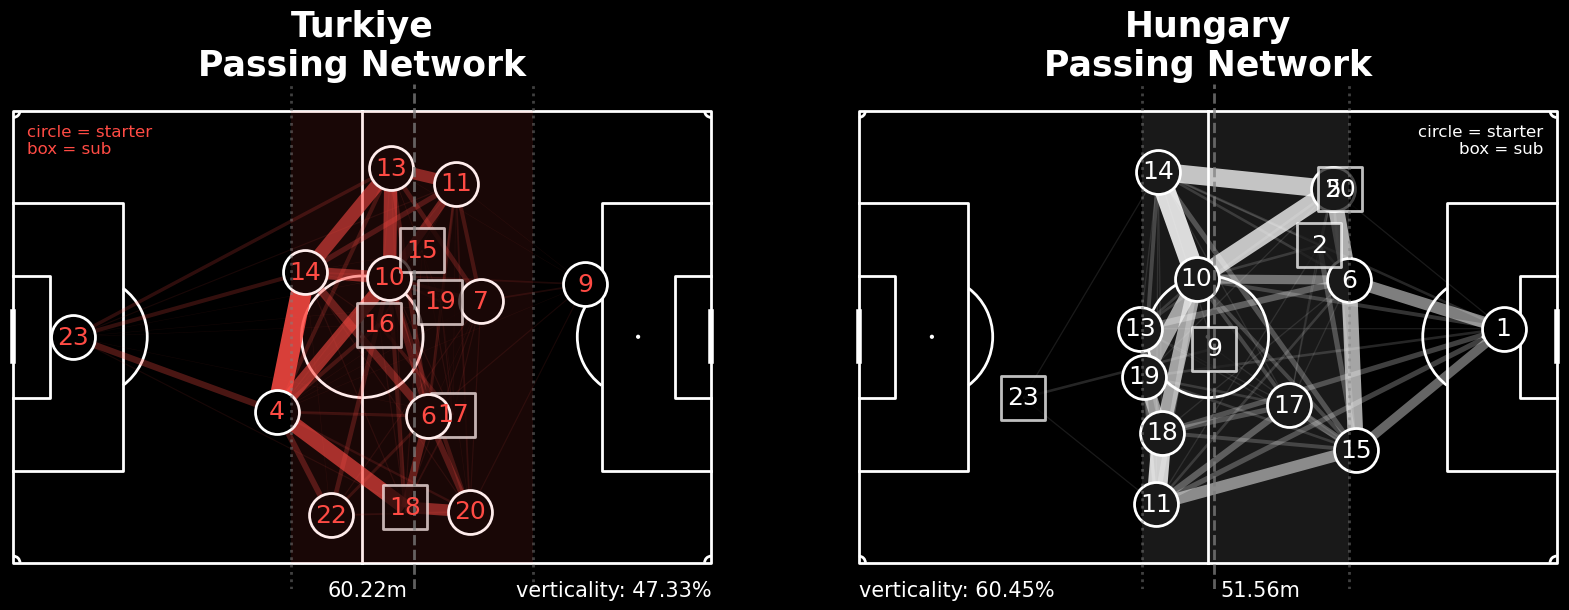

In [43]:
def get_passes_df(df):
    df1 = df[~df['type'].str.contains('SubstitutionOn|FormationChange|FormationSet|Card')]
    df = df1
    df.loc[:, "receiver"] = df["playerId"].shift(-1)
    passes_ids = df.index[df['type'] == 'Pass']
    df_passes = df.loc[passes_ids, ["index", "x", "y", "endX", "endY", "teamName", "playerId", "receiver", "type", "outcomeType", "pass_or_carry_angle"]]

    return df_passes

passes_df = get_passes_df(df)
path_eff = [path_effects.Stroke(linewidth=3, foreground=bg_color), path_effects.Normal()]

def get_passes_between_df(teamName, passes_df, players_df):
    passes_df = passes_df[(passes_df["teamName"] == teamName)]
    # df = pd.DataFrame(events_dict)
    dfteam = df[(df['teamName'] == teamName) & (~df['type'].str.contains('SubstitutionOn|FormationChange|FormationSet|Card'))]
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # calculate median positions for player's passes
    average_locs_and_count_df = (dfteam.groupby('playerId').agg({'x': ['median'], 'y': ['median', 'count']}))
    average_locs_and_count_df.columns = ['pass_avg_x', 'pass_avg_y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position', 'isFirstEleven']], on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')
    average_locs_and_count_df['name'] = average_locs_and_count_df['name'].apply(unidecode)
    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['index', 'playerId', 'receiver', 'teamName']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))
    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).index.count().reset_index()
    passes_between_df.rename({'index': 'pass_count'}, axis='columns', inplace=True)
    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True, suffixes=['', '_end'])

    return passes_between_df, average_locs_and_count_df

# home_team_id = list(teams_dict.keys())[0]
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(hteamName, passes_df, players_df)
# away_team_id = list(teams_dict.keys())[1]
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(ateamName, passes_df, players_df)

def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, col, teamName, flipped=False):
    MAX_LINE_WIDTH = 15
    MAX_MARKER_SIZE = 3000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *MAX_LINE_WIDTH)
    # average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']/ average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE) #You can plot variable size of each player's node according to their passing volume, in the plot using this
    MIN_TRANSPARENCY = 0.05
    MAX_TRANSPARENCY = 0.85
    color = np.array(to_rgba(col))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (MAX_TRANSPARENCY - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    # ax.set_ylim(-0.5, 68.5)

    # Plotting those lines between players
    pass_lines = pitch.lines(passes_between_df.pass_avg_x, passes_between_df.pass_avg_y, passes_between_df.pass_avg_x_end, passes_between_df.pass_avg_y_end,
                             lw=passes_between_df.width, color=color, zorder=1, ax=ax)

    # Plotting the player nodes
    for index, row in average_locs_and_count_df.iterrows():
      if row['isFirstEleven'] == True:
        pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=1000, marker='o', color=bg_color, edgecolor=line_color, linewidth=2, alpha=1, ax=ax)
      else:
        pass_nodes = pitch.scatter(row['pass_avg_x'], row['pass_avg_y'], s=1000, marker='s', color=bg_color, edgecolor=line_color, linewidth=2, alpha=0.75, ax=ax)

    # Plotting the shirt no. of each player
    for index, row in average_locs_and_count_df.iterrows():
        player_initials = row["shirtNo"]
        pitch.annotate(player_initials, xy=(row.pass_avg_x, row.pass_avg_y), c=col, ha='center', va='center', size=18, ax=ax)

    # Plotting a vertical line to show the median vertical position of all passes
    avgph = round(average_locs_and_count_df['pass_avg_x'].median(), 2)
    # avgph_show = round((avgph*1.05),2)
    avgph_show = avgph
    ax.axvline(x=avgph, color='gray', linestyle='--', alpha=0.75, linewidth=2)

    # Defense line Passing Height (avg. height of all the passes made by the Center Backs)
    center_backs_height = average_locs_and_count_df[average_locs_and_count_df['position']=='DC']
    def_line_h = round(center_backs_height['pass_avg_x'].median(), 2)
    ax.axvline(x=def_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)
    
    # Forward line Passing Height (avg. height of all the passes made by the Top 2 avg positoned Forwards)
    Forwards_height = average_locs_and_count_df[average_locs_and_count_df['isFirstEleven']==1]
    Forwards_height = Forwards_height.sort_values(by='pass_avg_x', ascending=False)
    Forwards_height = Forwards_height.head(2)
    fwd_line_h = round(Forwards_height['pass_avg_x'].mean(), 2)
    ax.axvline(x=fwd_line_h, color='gray', linestyle='dotted', alpha=0.5, linewidth=2)
    
    # coloring the middle zone in the pitch
    ymid = [0, 0, 68, 68]
    xmid = [def_line_h, fwd_line_h, fwd_line_h, def_line_h]
    ax.fill(xmid, ymid, col, alpha=0.1)

    # Getting the verticality of a team, (Verticality means how straight forward a team passes while advancing the ball, more the value = more directness in forward passing)
    team_passes_df = passes_df[(passes_df["teamName"] == teamName)]
    team_passes_df['pass_or_carry_angle'] = team_passes_df['pass_or_carry_angle'].abs()
    team_passes_df = team_passes_df[(team_passes_df['pass_or_carry_angle']>=0) & (team_passes_df['pass_or_carry_angle']<=90)]
    med_ang = team_passes_df['pass_or_carry_angle'].median()
    verticality = round((1 - med_ang/90)*100, 2)

    # Getting the top passers combination
    passes_between_df = passes_between_df.sort_values(by='pass_count', ascending=False).head(1).reset_index(drop=True)
    most_pass_from = passes_between_df['name'][0]
    most_pass_to = passes_between_df['name_end'][0]
    most_pass_count = passes_between_df['pass_count'][0]
    
    # Heading and other texts
    if teamName == ateamName:
      # inverting the pitch for away team
      ax.invert_xaxis()
      ax.invert_yaxis()
      ax.text(avgph-1, 73, f"{avgph_show}m", fontsize=15, color=line_color, ha='left')
      ax.text(105, 73,f"verticality: {verticality}%", fontsize=15, color=line_color, ha='left')
    else:
      ax.text(avgph-1, -5, f"{avgph_show}m", fontsize=15, color=line_color, ha='right')
      ax.text(105, -5, f"verticality: {verticality}%", fontsize=15, color=line_color, ha='right')

    # Headlines and other texts
    if teamName == hteamName:
      ax.text(2,66, "circle = starter\nbox = sub", color=hcol, size=12, ha='left', va='top')
      ax.set_title(f"{hteamName}\nPassing Network", color=line_color, size=25, fontweight='bold')

    else:
      ax.text(2,2, "circle = starter\nbox = sub", color=acol, size=12, ha='right', va='top')
      ax.set_title(f"{ateamName}\nPassing Network", color=line_color, size=25, fontweight='bold')

    # returnig the stats for storing those 
    return {
        'Team_Name': teamName,
        'Defense_Line_Height': def_line_h,
        'Vericality_%': verticality,
        'Most_pass_combination_from': most_pass_from,
        'Most_pass_combination_to': most_pass_to,
        'Most_passes_in_combination': most_pass_count,
    } 

fig,axs=plt.subplots(1,2, figsize=(20,10), facecolor=bg_color)
pass_network_stats_home = pass_network_visualization(axs[0], home_passes_between_df, home_average_locs_and_count_df, hcol, hteamName)
pass_network_stats_away = pass_network_visualization(axs[1], away_passes_between_df, away_average_locs_and_count_df, acol, ateamName)
pass_network_stats_list = []
pass_network_stats_list.append(pass_network_stats_home)
pass_network_stats_list.append(pass_network_stats_away)
pass_network_stats_df = pd.DataFrame(pass_network_stats_list)

In [44]:
# Get unique players
home_unique_players = homedf['name'].unique()
away_unique_players = awaydf['name'].unique()


# Top Ball Progressor
# Initialize an empty dictionary to store home players different type of pass counts
home_progressor_counts = {'name': home_unique_players, 'Progressive Passes': [], 'Progressive Carries': [], 'LineBreaking Pass': []}
for name in home_unique_players:
    home_progressor_counts['Progressive Passes'].append(len(df[(df['name'] == name) & (df['prog_pass'] >= 9.144) & (df['x']>=35) & (df['outcomeType']=='Successful') & (~df['qualifiers'].str.contains('CornerTaken|Freekick'))]))
    home_progressor_counts['Progressive Carries'].append(len(df[(df['name'] == name) & (df['prog_carry'] >= 9.144) & (df['endX']>=35)]))
    home_progressor_counts['LineBreaking Pass'].append(len(df[(df['name'] == name) & (df['type'] == 'Pass') & (df['qualifiers'].str.contains('Throughball'))]))
home_progressor_df = pd.DataFrame(home_progressor_counts)
home_progressor_df['total'] = home_progressor_df['Progressive Passes']+home_progressor_df['Progressive Carries']+home_progressor_df['LineBreaking Pass']
home_progressor_df = home_progressor_df.sort_values(by='total', ascending=False)
home_progressor_df.reset_index(drop=True, inplace=True)
home_progressor_df = home_progressor_df.head(5)
home_progressor_df['shortName'] = home_progressor_df['name'].apply(get_short_name)

# Initialize an empty dictionary to store away players different type of pass counts
away_progressor_counts = {'name': away_unique_players, 'Progressive Passes': [], 'Progressive Carries': [], 'LineBreaking Pass': []}
for name in away_unique_players:
    away_progressor_counts['Progressive Passes'].append(len(df[(df['name'] == name) & (df['prog_pass'] >= 9.144) & (df['x']>=35) & (df['outcomeType']=='Successful') & (~df['qualifiers'].str.contains('CornerTaken|Freekick'))]))
    away_progressor_counts['Progressive Carries'].append(len(df[(df['name'] == name) & (df['prog_carry'] >= 9.144) & (df['endX']>=35)]))
    away_progressor_counts['LineBreaking Pass'].append(len(df[(df['name'] == name) & (df['type'] == 'Pass') & (df['qualifiers'].str.contains('Throughball'))]))
away_progressor_df = pd.DataFrame(away_progressor_counts)
away_progressor_df['total'] = away_progressor_df['Progressive Passes']+away_progressor_df['Progressive Carries']+away_progressor_df['LineBreaking Pass']
away_progressor_df = away_progressor_df.sort_values(by='total', ascending=False)
away_progressor_df.reset_index(drop=True, inplace=True)
away_progressor_df = away_progressor_df.head(5)
away_progressor_df['shortName'] = away_progressor_df['name'].apply(get_short_name)


# Top Threate Creators
# Initialize an empty dictionary to store home players different type of Carries counts
home_xT_counts = {'name': home_unique_players, 'xT from Pass': [], 'xT from Carry': []}
for name in home_unique_players:
    home_xT_counts['xT from Pass'].append((df[(df['name'] == name) & (df['type'] == 'Pass') & (df['xT']>=0) & (df['outcomeType']=='Successful') & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))])['xT'].sum().round(2))
    home_xT_counts['xT from Carry'].append((df[(df['name'] == name) & (df['type'] == 'Carry') & (df['xT']>=0)])['xT'].sum().round(2))
home_xT_df = pd.DataFrame(home_xT_counts)
home_xT_df['total'] = home_xT_df['xT from Pass']+home_xT_df['xT from Carry']
home_xT_df = home_xT_df.sort_values(by='total', ascending=False)
home_xT_df.reset_index(drop=True, inplace=True)
home_xT_df = home_xT_df.head(5)
home_xT_df['shortName'] = home_xT_df['name'].apply(get_short_name)

# Initialize an empty dictionary to store home players different type of Carries counts
away_xT_counts = {'name': away_unique_players, 'xT from Pass': [], 'xT from Carry': []}
for name in away_unique_players:
    away_xT_counts['xT from Pass'].append((df[(df['name'] == name) & (df['type'] == 'Pass') & (df['xT']>=0) & (df['outcomeType']=='Successful') & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))])['xT'].sum().round(2))
    away_xT_counts['xT from Carry'].append((df[(df['name'] == name) & (df['type'] == 'Carry') & (df['xT']>=0)])['xT'].sum().round(2))
away_xT_df = pd.DataFrame(away_xT_counts)
away_xT_df['total'] = away_xT_df['xT from Pass']+away_xT_df['xT from Carry']
away_xT_df = away_xT_df.sort_values(by='total', ascending=False)
away_xT_df.reset_index(drop=True, inplace=True)
away_xT_df = away_xT_df.head(5)
away_xT_df['shortName'] = away_xT_df['name'].apply(get_short_name)


# Shot Sequence Involvement
df_no_carry = df[df['type']!='Carry']
# Initialize an empty dictionary to store home players different type of shot sequence counts
home_shot_seq_counts = {'name': home_unique_players, 'Shots': [], 'Shot Assist': [], 'Buildup to shot': []}
# Putting counts in those lists
for name in home_unique_players:
    home_shot_seq_counts['Shots'].append(len(df[(df['name'] == name) & ((df['type']=='MissedShots') | (df['type']=='SavedShot') | (df['type']=='ShotOnPost') | (df['type']=='Goal'))]))
    home_shot_seq_counts['Shot Assist'].append(len(df[(df['name'] == name) & (df['type'] == 'Pass') & (df['qualifiers'].str.contains('KeyPass'))]))
    home_shot_seq_counts['Buildup to shot'].append(len(df_no_carry[(df_no_carry['name'] == name) & (df_no_carry['type'] == 'Pass') & (df_no_carry['qualifiers'].shift(-1).str.contains('KeyPass'))]))
# converting that list into a dataframe
home_sh_sq_df = pd.DataFrame(home_shot_seq_counts)
home_sh_sq_df['total'] = home_sh_sq_df['Shots']+home_sh_sq_df['Shot Assist']+home_sh_sq_df['Buildup to shot']
home_sh_sq_df = home_sh_sq_df.sort_values(by='total', ascending=False)
home_sh_sq_df.reset_index(drop=True, inplace=True)
home_sh_sq_df = home_sh_sq_df.head(5)
home_sh_sq_df['shortName'] = home_sh_sq_df['name'].apply(get_short_name)

# Initialize an empty dictionary to store away players different type of shot sequence counts
away_shot_seq_counts = {'name': away_unique_players, 'Shots': [], 'Shot Assist': [], 'Buildup to shot': []}
for name in away_unique_players:
    away_shot_seq_counts['Shots'].append(len(df[(df['name'] == name) & ((df['type']=='MissedShots') | (df['type']=='SavedShot') | (df['type']=='ShotOnPost') | (df['type']=='Goal'))]))
    away_shot_seq_counts['Shot Assist'].append(len(df[(df['name'] == name) & (df['type'] == 'Pass') & (df['qualifiers'].str.contains('KeyPass'))]))
    away_shot_seq_counts['Buildup to shot'].append(len(df_no_carry[(df_no_carry['name'] == name) & (df_no_carry['type'] == 'Pass') & (df_no_carry['qualifiers'].shift(-1).str.contains('KeyPass'))]))
away_sh_sq_df = pd.DataFrame(away_shot_seq_counts)
away_sh_sq_df['total'] = away_sh_sq_df['Shots']+away_sh_sq_df['Shot Assist']+away_sh_sq_df['Buildup to shot']
away_sh_sq_df = away_sh_sq_df.sort_values(by='total', ascending=False)
away_sh_sq_df.reset_index(drop=True, inplace=True)
away_sh_sq_df = away_sh_sq_df.head(5)
away_sh_sq_df['shortName'] = away_sh_sq_df['name'].apply(get_short_name)


# Top Defenders
# Initialize an empty dictionary to store home players different type of defensive actions counts
home_defensive_actions_counts = {'name': home_unique_players, 'Tackles': [], 'Interceptions': [], 'Clearance': []}
for name in home_unique_players:
    home_defensive_actions_counts['Tackles'].append(len(df[(df['name'] == name) & (df['type'] == 'Tackle') & (df['outcomeType']=='Successful')]))
    home_defensive_actions_counts['Interceptions'].append(len(df[(df['name'] == name) & (df['type'] == 'Interception')]))
    home_defensive_actions_counts['Clearance'].append(len(df[(df['name'] == name) & (df['type'] == 'Clearance')]))
home_defender_df = pd.DataFrame(home_defensive_actions_counts)
home_defender_df['total'] = home_defender_df['Tackles']+home_defender_df['Interceptions']+home_defender_df['Clearance']
home_defender_df = home_defender_df.sort_values(by='total', ascending=False)
home_defender_df.reset_index(drop=True, inplace=True)
home_defender_df = home_defender_df.head(5)
home_defender_df['shortName'] = home_defender_df['name'].apply(get_short_name)

# Initialize an empty dictionary to store away players different type of defensive actions counts
away_defensive_actions_counts = {'name': away_unique_players, 'Tackles': [], 'Interceptions': [], 'Clearance': []}
for name in away_unique_players:
    away_defensive_actions_counts['Tackles'].append(len(df[(df['name'] == name) & (df['type'] == 'Tackle') & (df['outcomeType']=='Successful')]))
    away_defensive_actions_counts['Interceptions'].append(len(df[(df['name'] == name) & (df['type'] == 'Interception')]))
    away_defensive_actions_counts['Clearance'].append(len(df[(df['name'] == name) & (df['type'] == 'Clearance')]))
away_defender_df = pd.DataFrame(away_defensive_actions_counts)
away_defender_df['total'] = away_defender_df['Tackles']+away_defender_df['Interceptions']+away_defender_df['Clearance']
away_defender_df = away_defender_df.sort_values(by='total', ascending=False)
away_defender_df.reset_index(drop=True, inplace=True)
away_defender_df = away_defender_df.head(5)
away_defender_df['shortName'] = away_defender_df['name'].apply(get_short_name)

In [45]:
# Get unique players
unique_players = df['name'].unique()


# Top Ball Progressor
# Initialize an empty dictionary to store both team's players different type of pass counts
progressor_counts = {'name': unique_players, 'Progressive Passes': [], 'Progressive Carries': [], 'LineBreaking Pass': []}
for name in unique_players:
    progressor_counts['Progressive Passes'].append(len(df[(df['name'] == name) & (df['prog_pass'] >= 9.144) & (df['x']>=35) & (df['outcomeType']=='Successful') & (~df['qualifiers'].str.contains('CornerTaken|Freekick'))]))
    progressor_counts['Progressive Carries'].append(len(df[(df['name'] == name) & (df['prog_carry'] >= 9.144) & (df['endX']>=35)]))
    progressor_counts['LineBreaking Pass'].append(len(df[(df['name'] == name) & (df['type'] == 'Pass') & (df['qualifiers'].str.contains('Throughball'))]))
progressor_df = pd.DataFrame(progressor_counts)
progressor_df['total'] = progressor_df['Progressive Passes']+progressor_df['Progressive Carries']+progressor_df['LineBreaking Pass']
progressor_df = progressor_df.sort_values(by='total', ascending=False)
progressor_df.reset_index(drop=True, inplace=True)
progressor_df = progressor_df.head(10)
progressor_df['shortName'] = progressor_df['name'].apply(get_short_name)




# Top Threate Creators
# Initialize an empty dictionary to store both team's players different type of Carries counts
xT_counts = {'name': unique_players, 'xT from Pass': [], 'xT from Carry': []}
for name in unique_players:
    xT_counts['xT from Pass'].append((df[(df['name'] == name) & (df['type'] == 'Pass') & (df['xT']>=0) & (df['outcomeType']=='Successful') & (~df['qualifiers'].str.contains('CornerTaken|Freekick|ThrowIn'))])['xT'].sum().round(2))
    xT_counts['xT from Carry'].append((df[(df['name'] == name) & (df['type'] == 'Carry') & (df['xT']>=0)])['xT'].sum().round(2))
xT_df = pd.DataFrame(xT_counts)
xT_df['total'] = xT_df['xT from Pass']+xT_df['xT from Carry']
xT_df = xT_df.sort_values(by='total', ascending=False)
xT_df.reset_index(drop=True, inplace=True)
xT_df = xT_df.head(10)
xT_df['shortName'] = xT_df['name'].apply(get_short_name)




# Shot Sequence Involvement
df_no_carry = df[df['type']!='Carry']
# Initialize an empty dictionary to store both team's players different type of shot sequence counts
shot_seq_counts = {'name': unique_players, 'Shots': [], 'Shot Assist': [], 'Buildup to shot': []}
# Putting counts in those lists
for name in unique_players:
    shot_seq_counts['Shots'].append(len(df[(df['name'] == name) & ((df['type']=='MissedShots') | (df['type']=='SavedShot') | (df['type']=='ShotOnPost') | (df['type']=='Goal'))]))
    shot_seq_counts['Shot Assist'].append(len(df[(df['name'] == name) & (df['type'] == 'Pass') & (df['qualifiers'].str.contains('KeyPass'))]))
    shot_seq_counts['Buildup to shot'].append(len(df_no_carry[(df_no_carry['name'] == name) & (df_no_carry['type'] == 'Pass') & (df_no_carry['qualifiers'].shift(-1).str.contains('KeyPass'))]))
# converting that list into a dataframe
sh_sq_df = pd.DataFrame(shot_seq_counts)
sh_sq_df['total'] = sh_sq_df['Shots']+sh_sq_df['Shot Assist']+sh_sq_df['Buildup to shot']
sh_sq_df = sh_sq_df.sort_values(by='total', ascending=False)
sh_sq_df.reset_index(drop=True, inplace=True)
sh_sq_df = sh_sq_df.head(10)
sh_sq_df['shortName'] = sh_sq_df['name'].apply(get_short_name)




# Top Defenders
# Initialize an empty dictionary to store both team's players different type of defensive actions counts
defensive_actions_counts = {'name': unique_players, 'Tackles': [], 'Interceptions': [], 'Clearance': []}
for name in unique_players:
    defensive_actions_counts['Tackles'].append(len(df[(df['name'] == name) & (df['type'] == 'Tackle') & (df['outcomeType']=='Successful')]))
    defensive_actions_counts['Interceptions'].append(len(df[(df['name'] == name) & (df['type'] == 'Interception')]))
    defensive_actions_counts['Clearance'].append(len(df[(df['name'] == name) & (df['type'] == 'Clearance')]))
defender_df = pd.DataFrame(defensive_actions_counts)
defender_df['total'] = defender_df['Tackles']+defender_df['Interceptions']+defender_df['Clearance']
defender_df = defender_df.sort_values(by='total', ascending=False)
defender_df.reset_index(drop=True, inplace=True)
defender_df = defender_df.head(10)
defender_df['shortName'] = defender_df['name'].apply(get_short_name)

In [46]:
def home_player_passmap(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5, 68.5)

    # taking the top home passer and plotting his passmap
    home_player_name = home_progressor_df['name'].iloc[0]

    acc_pass = df[(df['name']==home_player_name) & (df['type']=='Pass') & (df['outcomeType']=='Successful')]
    pro_pass = acc_pass[(acc_pass['prog_pass']>=9.11) & (acc_pass['x']>=35) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    pro_carry = df[(df['name']==home_player_name) & (df['prog_carry']>=9.11) & (df['endX']>=35)]
    key_pass = acc_pass[acc_pass['qualifiers'].str.contains('KeyPass')]
    g_assist = acc_pass[acc_pass['qualifiers'].str.contains('GoalAssist')]

    pitch.lines(acc_pass.x, acc_pass.y, acc_pass.endX, acc_pass.endY, color=line_color, lw=2, alpha=0.15, comet=True, zorder=2, ax=ax)
    pitch.lines(pro_pass.x, pro_pass.y, pro_pass.endX, pro_pass.endY, color=hcol      , lw=3, alpha=1,    comet=True, zorder=3, ax=ax)
    pitch.lines(key_pass.x, key_pass.y, key_pass.endX, key_pass.endY, color=violet,     lw=4, alpha=1,    comet=True, zorder=4, ax=ax)
    pitch.lines(g_assist.x, g_assist.y, g_assist.endX, g_assist.endY, color='green',      lw=4, alpha=1,    comet=True, zorder=5, ax=ax)

    ax.scatter(acc_pass.endX, acc_pass.endY, s=30, color=bg_color,    edgecolor='gray', alpha=1, zorder=2)
    ax.scatter(pro_pass.endX, pro_pass.endY, s=40, color=bg_color,  edgecolor= hcol,  alpha=1, zorder=3)
    ax.scatter(key_pass.endX, key_pass.endY, s=50, color=bg_color,  edgecolor=violet, alpha=1, zorder=4)
    ax.scatter(g_assist.endX, g_assist.endY, s=50, color=bg_color,  edgecolor= 'green', alpha=1, zorder=5)

    for index, row in pro_carry.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', color=hcol, zorder=4, mutation_scale=20, 
                                        alpha=0.9, linewidth=2, linestyle='--')
        ax.add_patch(arrow) 


    home_name_show = home_progressor_df['shortName'].iloc[0]
    ax.set_title(f"{home_name_show} PassMap", color=hcol, fontsize=25, fontweight='bold', y=1.03)
    ax.text(0,-3, f'Prog. Pass: {len(pro_pass)}          Prog. Carry: {len(pro_carry)}', fontsize=15, color=hcol, ha='left', va='center')
    ax_text(105,-3, s=f'Key Pass: {len(key_pass)}          <Assist: {len(g_assist)}>', fontsize=15, color=violet, ha='right', va='center',
            highlight_textprops=[{'color':'green'}], ax=ax)

def away_player_passmap(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5, 68.5)
    ax.invert_xaxis()
    ax.invert_yaxis()

    # taking the top away passer and plotting his passmap
    away_player_name = away_progressor_df['name'].iloc[0]
    
    acc_pass = df[(df['name']==away_player_name) & (df['type']=='Pass') & (df['outcomeType']=='Successful')]
    pro_pass = acc_pass[(acc_pass['prog_pass']>=9.11) & (acc_pass['x']>=35) & (~acc_pass['qualifiers'].str.contains('CornerTaken|Freekick'))]
    pro_carry = df[(df['name']==away_player_name) & (df['prog_carry']>=9.11) & (df['endX']>=35)]
    key_pass = acc_pass[acc_pass['qualifiers'].str.contains('KeyPass')]
    g_assist = acc_pass[acc_pass['qualifiers'].str.contains('GoalAssist')]

    pitch.lines(acc_pass.x, acc_pass.y, acc_pass.endX, acc_pass.endY, color=line_color, lw=2, alpha=0.15, comet=True, zorder=2, ax=ax)
    pitch.lines(pro_pass.x, pro_pass.y, pro_pass.endX, pro_pass.endY, color=acol      , lw=3, alpha=1,    comet=True, zorder=3, ax=ax)
    pitch.lines(key_pass.x, key_pass.y, key_pass.endX, key_pass.endY, color=violet,     lw=4, alpha=1,    comet=True, zorder=4, ax=ax)
    pitch.lines(g_assist.x, g_assist.y, g_assist.endX, g_assist.endY, color='green',      lw=4, alpha=1,    comet=True, zorder=5, ax=ax)

    ax.scatter(acc_pass.endX, acc_pass.endY, s=30, color=bg_color,    edgecolor='gray', alpha=1, zorder=2)
    ax.scatter(pro_pass.endX, pro_pass.endY, s=40, color=bg_color,  edgecolor= acol,  alpha=1, zorder=3)
    ax.scatter(key_pass.endX, key_pass.endY, s=50, color=bg_color,  edgecolor=violet, alpha=1, zorder=4)
    ax.scatter(g_assist.endX, g_assist.endY, s=50, color=bg_color,  edgecolor= 'green', alpha=1, zorder=5)

    for index, row in pro_carry.iterrows():
        arrow = patches.FancyArrowPatch((row['x'], row['y']), (row['endX'], row['endY']), arrowstyle='->', color=acol, zorder=4, mutation_scale=20, 
                                        alpha=0.9, linewidth=2, linestyle='--')
        ax.add_patch(arrow) 


    away_name_show = away_progressor_df['shortName'].iloc[0]
    ax.set_title(f"{away_name_show} PassMap", color=acol, fontsize=25, fontweight='bold', y=1.03)
    ax.text(0,71, f'Prog. Pass: {len(pro_pass)}          Prog. Carry: {len(pro_carry)}', fontsize=15, color=acol, ha='right', va='center')
    ax_text(105,71, s=f'Key Pass: {len(key_pass)}          <Assist: {len(g_assist)}>', fontsize=15, color=violet, ha='left', va='center',
            highlight_textprops=[{'color':'green'}], ax=ax)

# fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
# home_player_passmap(ax)

In [47]:
def get_short_name(full_name):
    if not isinstance(full_name, str):
        return None  # Return None if the input is not a string
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

def home_passes_recieved(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5, 68.5)

    # plotting the home center forward pass receiving
    name = home_average_locs_and_count_df.loc[home_average_locs_and_count_df['position'] == 'FW', 'name'].tolist()[0]
    name_show = get_short_name(name)
    filtered_rows = df[(df['type'] == 'Pass') & (df['outcomeType'] == 'Successful') & (df['name'].shift(-1) == name)]
    keypass_recieved_df = filtered_rows[filtered_rows['qualifiers'].str.contains('KeyPass')]
    assist_recieved_df = filtered_rows[filtered_rows['qualifiers'].str.contains('IntentionalGoalAssist')]
    pr = len(filtered_rows)
    kpr = len(keypass_recieved_df)
    ar = len(assist_recieved_df)

    lc1 = pitch.lines(filtered_rows.x, filtered_rows.y, filtered_rows.endX, filtered_rows.endY, lw=3, transparent=True, comet=True,color=hcol, ax=ax, alpha=0.5)
    lc2 = pitch.lines(keypass_recieved_df.x, keypass_recieved_df.y, keypass_recieved_df.endX, keypass_recieved_df.endY, lw=4, transparent=True, comet=True,color=violet, ax=ax, alpha=0.75)
    lc3 = pitch.lines(assist_recieved_df.x, assist_recieved_df.y, assist_recieved_df.endX, assist_recieved_df.endY, lw=4, transparent=True, comet=True,color='green', ax=ax, alpha=0.75)
    sc1 = pitch.scatter(filtered_rows.endX, filtered_rows.endY, s=30, edgecolor=hcol, linewidth=1, color=bg_color, zorder=2, ax=ax)
    sc2 = pitch.scatter(keypass_recieved_df.endX, keypass_recieved_df.endY, s=40, edgecolor=violet, linewidth=1.5, color=bg_color, zorder=2, ax=ax)
    sc3 = pitch.scatter(assist_recieved_df.endX, assist_recieved_df.endY, s=50, edgecolors='green', linewidths=1, marker='football', c=bg_color, zorder=2, ax=ax)

    avg_endY = filtered_rows['endY'].median()
    avg_endX = filtered_rows['endX'].median()
    ax.axvline(x=avg_endX, ymin=0, ymax=68, color='gray', linestyle='--', alpha=0.6, linewidth=2)
    ax.axhline(y=avg_endY, xmin=0, xmax=105, color='gray', linestyle='--', alpha=0.6, linewidth=2)
    ax.set_title(f"{name_show} Passes Recieved", color=hcol, fontsize=25, fontweight='bold', y=1.03)
    highlight_text=[{'color':violet}, {'color':'green'}]
    ax_text(52.5,-3, f'Passes Recieved:{pr+kpr} | <Keypasses Recieved:{kpr}> | <Assist Received: {ar}>', color=line_color, fontsize=15, ha='center', 
            va='center', highlight_textprops=highlight_text, ax=ax)

    return

def away_passes_recieved(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5, 68.5)
    ax.invert_xaxis()
    ax.invert_yaxis()

    # plotting the away center forward pass receiving
    name = away_average_locs_and_count_df.loc[away_average_locs_and_count_df['position'] == 'FW', 'name'].tolist()[0]
    name_show = get_short_name(name)
    filtered_rows = df[(df['type'] == 'Pass') & (df['outcomeType'] == 'Successful') & (df['name'].shift(-1) == name)]
    keypass_recieved_df = filtered_rows[filtered_rows['qualifiers'].str.contains('KeyPass')]
    assist_recieved_df = filtered_rows[filtered_rows['qualifiers'].str.contains('IntentionalGoalAssist')]
    pr = len(filtered_rows)
    kpr = len(keypass_recieved_df)
    ar = len(assist_recieved_df)

    lc1 = pitch.lines(filtered_rows.x, filtered_rows.y, filtered_rows.endX, filtered_rows.endY, lw=3, transparent=True, comet=True,color=acol, ax=ax, alpha=0.5)
    lc2 = pitch.lines(keypass_recieved_df.x, keypass_recieved_df.y, keypass_recieved_df.endX, keypass_recieved_df.endY, lw=4, transparent=True, comet=True,color=violet, ax=ax, alpha=0.75)
    lc3 = pitch.lines(assist_recieved_df.x, assist_recieved_df.y, assist_recieved_df.endX, assist_recieved_df.endY, lw=4, transparent=True, comet=True,color='green', ax=ax, alpha=0.75)
    sc1 = pitch.scatter(filtered_rows.endX, filtered_rows.endY, s=30, edgecolor=acol, linewidth=1, color=bg_color, zorder=2, ax=ax)
    sc2 = pitch.scatter(keypass_recieved_df.endX, keypass_recieved_df.endY, s=40, edgecolor=violet, linewidth=1.5, color=bg_color, zorder=2, ax=ax)
    sc3 = pitch.scatter(assist_recieved_df.endX, assist_recieved_df.endY, s=50, edgecolors='green', linewidths=1, marker='football', c=bg_color, zorder=2, ax=ax)

    avg_endX = filtered_rows['endX'].median()
    avg_endY = filtered_rows['endY'].median()
    ax.axvline(x=avg_endX, ymin=0, ymax=68, color='gray', linestyle='--', alpha=0.6, linewidth=2)
    ax.axhline(y=avg_endY, xmin=0, xmax=105, color='gray', linestyle='--', alpha=0.6, linewidth=2)
    ax.set_title(f"{name_show} Passes Recieved", color=acol, fontsize=25, fontweight='bold', y=1.03)
    highlight_text=[{'color':violet}, {'color':'green'}]
    ax_text(52.5,71, f'Passes Recieved:{pr+kpr} | <Keypasses Recieved:{kpr}> | <Assist Received: {ar}>', color=line_color, fontsize=15, ha='center', 
            va='center', highlight_textprops=highlight_text, ax=ax)

    return

# fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
# home_passes_recieved(ax)

In [48]:
def home_player_def_acts(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, line_zorder=2, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-12,68.5)

    # taking the top home defender and plotting his defensive actions
    home_player_name = home_defender_df['name'].iloc[0]
    home_playerdf = df[(df['name']==home_player_name)]

    hp_tk = home_playerdf[home_playerdf['type']=='Tackle']
    hp_intc = home_playerdf[(home_playerdf['type']=='Interception') | (home_playerdf['type']=='BlockedPass')]
    hp_br = home_playerdf[home_playerdf['type']=='BallRecovery']
    hp_cl = home_playerdf[home_playerdf['type']=='Clearance']
    hp_fl = home_playerdf[home_playerdf['type']=='Foul']
    hp_ar = home_playerdf[(home_playerdf['type']=='Aerial') & (home_playerdf['qualifiers'].str.contains('Defensive'))]

    sc1 = pitch.scatter(hp_tk.x, hp_tk.y, s=250, c=hcol, lw=2.5, edgecolor=hcol, marker='+', hatch='/////', ax=ax)
    sc2 = pitch.scatter(hp_intc.x, hp_intc.y, s=250, c='None', lw=2.5, edgecolor=hcol, marker='s', hatch='/////', ax=ax)
    sc3 = pitch.scatter(hp_br.x, hp_br.y, s=250, c='None', lw=2.5, edgecolor=hcol, marker='o', hatch='/////', ax=ax)
    sc4 = pitch.scatter(hp_cl.x, hp_cl.y, s=250, c='None', lw=2.5, edgecolor=hcol, marker='d', hatch='/////', ax=ax)
    sc5 = pitch.scatter(hp_fl.x, hp_fl.y, s=250, c=hcol, lw=2.5, edgecolor=hcol, marker='x', hatch='/////', ax=ax)
    sc6 = pitch.scatter(hp_ar.x, hp_ar.y, s=250, c='None', lw=2.5, edgecolor=hcol, marker='^', hatch='/////', ax=ax)

    sc7 =  pitch.scatter(2, -4, s=150, c=hcol, lw=2.5, edgecolor=hcol, marker='+', hatch='/////', ax=ax)
    sc8 =  pitch.scatter(2, -10, s=150, c='None', lw=2.5, edgecolor=hcol, marker='s', hatch='/////', ax=ax)
    sc9 =  pitch.scatter(41, -4, s=150, c='None', lw=2.5, edgecolor=hcol, marker='o', hatch='/////', ax=ax)
    sc10 = pitch.scatter(41, -10, s=150, c='None', lw=2.5, edgecolor=hcol, marker='d', hatch='/////', ax=ax)
    sc11 = pitch.scatter(103, -4, s=150, c=hcol, lw=2.5, edgecolor=hcol, marker='x', hatch='/////', ax=ax)
    sc12 = pitch.scatter(103, -10, s=150, c='None', lw=2.5, edgecolor=hcol, marker='^', hatch='/////', ax=ax)

    ax.text(5, -3, f"Tackle: {len(hp_tk)}\n\nInterception: {len(hp_intc)}", color=hcol, ha='left', va='top', fontsize=13)
    ax.text(43, -3, f"BallRecovery: {len(hp_br)}\n\nClearance: {len(hp_cl)}", color=hcol, ha='left', va='top', fontsize=13)
    ax.text(100, -3, f"{len(hp_fl)} Fouls\n\n{len(hp_ar)} Aerials", color=hcol, ha='right', va='top', fontsize=13)

    home_name_show = home_defender_df['shortName'].iloc[0]
    ax.set_title(f"{home_name_show} Defensive Actions", color=hcol, fontsize=25, fontweight='bold')

def away_player_def_acts(ax):
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, line_zorder=2, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5,80)
    ax.invert_xaxis()
    ax.invert_yaxis()

    # taking the top home defender and plotting his defensive actions
    away_player_name = away_defender_df['name'].iloc[0]
    away_playerdf = df[(df['name']==away_player_name)]

    ap_tk = away_playerdf[away_playerdf['type']=='Tackle']
    ap_intc = away_playerdf[(away_playerdf['type']=='Interception') | (away_playerdf['type']=='BlockedPass')]
    ap_br = away_playerdf[away_playerdf['type']=='BallRecovery']
    ap_cl = away_playerdf[away_playerdf['type']=='Clearance']
    ap_fl = away_playerdf[away_playerdf['type']=='Foul']
    ap_ar = away_playerdf[(away_playerdf['type']=='Aerial') & (away_playerdf['qualifiers'].str.contains('Defensive'))]

    sc1 = pitch.scatter(ap_tk.x, ap_tk.y, s=250, c=acol, lw=2.5, edgecolor=acol, marker='+', hatch='/////', ax=ax)
    sc2 = pitch.scatter(ap_intc.x, ap_intc.y, s=250, c='None', lw=2.5, edgecolor=acol, marker='s', hatch='/////', ax=ax)
    sc3 = pitch.scatter(ap_br.x, ap_br.y, s=250, c='None', lw=2.5, edgecolor=acol, marker='o', hatch='/////', ax=ax)
    sc4 = pitch.scatter(ap_cl.x, ap_cl.y, s=250, c='None', lw=2.5, edgecolor=acol, marker='d', hatch='/////', ax=ax)
    sc5 = pitch.scatter(ap_fl.x, ap_fl.y, s=250, c=acol, lw=2.5, edgecolor=acol, marker='x', hatch='/////', ax=ax)
    sc6 = pitch.scatter(ap_ar.x, ap_ar.y, s=250, c='None', lw=2.5, edgecolor=acol, marker='^', hatch='/////', ax=ax)

    sc7 =  pitch.scatter(2, 72, s=150, c=acol, lw=2.5, edgecolor=acol, marker='+', hatch='/////', ax=ax)
    sc8 =  pitch.scatter(2, 78, s=150, c='None', lw=2.5, edgecolor=acol, marker='s', hatch='/////', ax=ax)
    sc9 =  pitch.scatter(41, 72, s=150, c='None', lw=2.5, edgecolor=acol, marker='o', hatch='/////', ax=ax)
    sc10 = pitch.scatter(41, 78, s=150, c='None', lw=2.5, edgecolor=acol, marker='d', hatch='/////', ax=ax)
    sc11 = pitch.scatter(103, 72, s=150, c=acol, lw=2.5, edgecolor=acol, marker='x', hatch='/////', ax=ax)
    sc12 = pitch.scatter(103, 78, s=150, c='None', lw=2.5, edgecolor=acol, marker='^', hatch='/////', ax=ax)

    ax.text(5, 71, f"Tackle: {len(ap_tk)}\n\nInterception: {len(ap_intc)}", color=acol, ha='right', va='top', fontsize=13)
    ax.text(43, 71, f"BallRecovery: {len(ap_br)}\n\nClearance: {len(ap_cl)}", color=acol, ha='right', va='top', fontsize=13)
    ax.text(100, 71, f"{len(ap_fl)} Fouls\n\n{len(ap_ar)} Aerials", color=acol, ha='left', va='top', fontsize=13)

    away_name_show = away_defender_df['shortName'].iloc[0]
    ax.set_title(f"{away_name_show} Defensive Actions", color=acol, fontsize=25, fontweight='bold')

# fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
# away_player_def_acts(ax)

In [49]:
def home_gk(ax):
    df_gk = df[(df['teamName']==hteamName) & (df['position']=='GK')]
    gk_pass = df_gk[df_gk['type']=='Pass']
    op_pass = df_gk[(df_gk['type']=='Pass') & (~df_gk['qualifiers'].str.contains('GoalKick|FreekickTaken'))]
    sp_pass = df_gk[(df_gk['type']=='Pass') &  (df_gk['qualifiers'].str.contains('GoalKick|FreekickTaken'))]
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5, 68.5)
    gk_name = df_gk['shortName'].unique()[0]
    op_succ = sp_succ = 0
    for index, row in op_pass.iterrows():
        if row['outcomeType']=='Successful':
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=hcol, lw=4, comet=True, alpha=0.5, zorder=2, ax=ax)
            ax.scatter(row['endX'], row['endY'], s=40, color=hcol, edgecolor=line_color, zorder=3)
            op_succ += 1
        if row['outcomeType']=='Unsuccessful':
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=hcol, lw=4, comet=True, alpha=0.5, zorder=2, ax=ax)
            ax.scatter(row['endX'], row['endY'], s=40, color=bg_color, edgecolor=hcol, zorder=3)
    for index, row in sp_pass.iterrows():
        if row['outcomeType']=='Successful':
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=violet, lw=4, comet=True, alpha=0.5, zorder=2, ax=ax)
            ax.scatter(row['endX'], row['endY'], s=40, color=violet, edgecolor=line_color, zorder=3)
            sp_succ += 1
        if row['outcomeType']=='Unsuccessful':
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=violet, lw=4, comet=True, alpha=0.35, zorder=2, ax=ax)
            ax.scatter(row['endX'], row['endY'], s=40, color=bg_color, edgecolor=violet, zorder=3)

    gk_pass['length'] = np.sqrt((gk_pass['x']-gk_pass['endX'])**2 + (gk_pass['y']-gk_pass['endY'])**2)
    avg_len = gk_pass['length'].mean().round(2)
    avg_hgh = gk_pass['endX'].mean().round(2)
    
    ax.set_title(f'{gk_name} PassMap', color=hcol, fontsize=25, fontweight='bold', y=1.07)
    ax.text(52.5, -3, f'Avg. Passing Length: {avg_len}     |     Avg. Passign Height: {avg_hgh}', color=line_color, fontsize=15, ha='center', va='center')
    ax_text(52.5, 70, s=f'<Open-play Pass (Acc.): {len(op_pass)} ({op_succ})>     |     <GoalKick/Freekick (Acc.): {len(sp_pass)} ({sp_succ})>', 
            fontsize=15, highlight_textprops=[{'color':hcol}, {'color':violet}], ha='center', va='center', ax=ax)

    return

def away_gk(ax):
    df_gk = df[(df['teamName']==ateamName) & (df['position']=='GK')]
    gk_pass = df_gk[df_gk['type']=='Pass']
    op_pass = df_gk[(df_gk['type']=='Pass') & (~df_gk['qualifiers'].str.contains('GoalKick|FreekickTaken'))]
    sp_pass = df_gk[(df_gk['type']=='Pass') &  (df_gk['qualifiers'].str.contains('GoalKick|FreekickTaken'))]
    pitch = Pitch(pitch_type='uefa', corner_arcs=True, pitch_color=bg_color, line_color=line_color, linewidth=2)
    pitch.draw(ax=ax)
    ax.set_xlim(-0.5, 105.5)
    ax.set_ylim(-0.5, 68.5)
    ax.invert_xaxis()
    ax.invert_yaxis()
    gk_name = df_gk['shortName'].unique()[0]
    op_succ = sp_succ = 0
    for index, row in op_pass.iterrows():
        if row['outcomeType']=='Successful':
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=acol, lw=4, comet=True, alpha=0.5, zorder=2, ax=ax)
            ax.scatter(row['endX'], row['endY'], s=40, color=acol, edgecolor=line_color, zorder=3)
            op_succ += 1
        if row['outcomeType']=='Unsuccessful':
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=acol, lw=4, comet=True, alpha=0.5, zorder=2, ax=ax)
            ax.scatter(row['endX'], row['endY'], s=40, color=bg_color, edgecolor=acol, zorder=3)
    for index, row in sp_pass.iterrows():
        if row['outcomeType']=='Successful':
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=violet, lw=4, comet=True, alpha=0.5, zorder=2, ax=ax)
            ax.scatter(row['endX'], row['endY'], s=40, color=violet, edgecolor=line_color, zorder=3)
            sp_succ += 1
        if row['outcomeType']=='Unsuccessful':
            pitch.lines(row['x'], row['y'], row['endX'], row['endY'], color=violet, lw=4, comet=True, alpha=0.35, zorder=2, ax=ax)
            ax.scatter(row['endX'], row['endY'], s=40, color=bg_color, edgecolor=violet, zorder=3)

    gk_pass['length'] = np.sqrt((gk_pass['x']-gk_pass['endX'])**2 + (gk_pass['y']-gk_pass['endY'])**2)
    avg_len = gk_pass['length'].mean().round(2)
    avg_hgh = gk_pass['endX'].mean().round(2)

    ax.set_title(f'{gk_name} PassMap', color=acol, fontsize=25, fontweight='bold', y=1.07)
    ax.text(52.5, 71, f'Avg. Passing Length: {avg_len}     |     Avg. Passing Height: {avg_hgh}', color=line_color, fontsize=15, ha='center', va='center')
    ax_text(52.5, -2, s=f'<Open-play Pass (Acc.): {len(op_pass)} ({op_succ})>     |     <GoalKick/Freekick (Acc.): {len(sp_pass)} ({sp_succ})>', 
            fontsize=15, highlight_textprops=[{'color':acol}, {'color':violet}], ha='center', va='center', ax=ax)

    return

# fig,ax=plt.subplots(figsize=(10,10), facecolor=bg_color)
# home_gk(ax)

In [50]:
from matplotlib.ticker import MaxNLocator
def sh_sq_bar(ax):
  top10_sh_sq = sh_sq_df.nsmallest(10, 'total')['shortName'].tolist()

  shsq_sh = sh_sq_df.nsmallest(10, 'total')['Shots'].tolist()
  shsq_sa = sh_sq_df.nsmallest(10, 'total')['Shot Assist'].tolist()
  shsq_bs = sh_sq_df.nsmallest(10, 'total')['Buildup to shot'].tolist()

  left1 = [w + x for w, x in zip(shsq_sh, shsq_sa)]

  ax.barh(top10_sh_sq, shsq_sh, label='Shot', color=col1, left=0)
  ax.barh(top10_sh_sq, shsq_sa, label='Shot Assist', color=violet, left=shsq_sh)
  ax.barh(top10_sh_sq, shsq_bs, label='Buildup to Shot', color=col2, left=left1)

  # Add counts in the middle of the bars (if count > 0)
  for i, player in enumerate(top10_sh_sq):
      for j, count in enumerate([shsq_sh[i], shsq_sa[i], shsq_bs[i]]):
          if count > 0:
              x_position = sum([shsq_sh[i], shsq_sa[i]][:j]) + count / 2
              ax.text(x_position, i, str(count), ha='center', va='center', color=bg_color, fontsize=13, fontweight='bold')

  max_x = sh_sq_df['total'].iloc()[0]
  x_coord = [2 * i for i in range(1, int(max_x/2))]
  for x in x_coord:
      ax.axvline(x=x, color='gray', linestyle='--', zorder=2, alpha=0.5)

  ax.set_facecolor(bg_color)
  ax.tick_params(axis='x', colors=line_color, labelsize=15)
  ax.tick_params(axis='y', colors=line_color, labelsize=15)
  ax.xaxis.label.set_color(line_color)
  ax.yaxis.label.set_color(line_color)
  for spine in ax.spines.values():
    spine.set_edgecolor(bg_color)

  ax.set_title(f"Shot Sequence Involvement", color=line_color, fontsize=25, fontweight='bold')
  ax.legend()

def passer_bar(ax):
  top10_passers = progressor_df.nsmallest(10, 'total')['shortName'].tolist()

  passers_pp = progressor_df.nsmallest(10, 'total')['Progressive Passes'].tolist()
  passers_tp = progressor_df.nsmallest(10, 'total')['Progressive Carries'].tolist()
  passers_kp = progressor_df.nsmallest(10, 'total')['LineBreaking Pass'].tolist()

  left1 = [w + x for w, x in zip(passers_pp, passers_tp)]

  ax.barh(top10_passers, passers_pp, label='Prog. Pass', color=col1, left=0)
  ax.barh(top10_passers, passers_tp, label='Prog. Carries', color=col2, left=passers_pp)
  ax.barh(top10_passers, passers_kp, label='Through Pass', color=violet, left=left1)

  # Add counts in the middle of the bars (if count > 0)
  for i, player in enumerate(top10_passers):
      for j, count in enumerate([passers_pp[i], passers_tp[i], passers_kp[i]]):
          if count > 0:
              x_position = sum([passers_pp[i], passers_tp[i]][:j]) + count / 2
              ax.text(x_position, i, str(count), ha='center', va='center', color=bg_color, fontsize=13, fontweight='bold')

  max_x = progressor_df['total'].iloc()[0]
  x_coord = [2 * i for i in range(1, int(max_x/2))]
  for x in x_coord:
      ax.axvline(x=x, color='gray', linestyle='--', zorder=2, alpha=0.5)

  ax.set_facecolor(bg_color)
  ax.tick_params(axis='x', colors=line_color, labelsize=15)
  ax.tick_params(axis='y', colors=line_color, labelsize=15)
  ax.xaxis.label.set_color(line_color)
  ax.yaxis.label.set_color(line_color)
  for spine in ax.spines.values():
    spine.set_edgecolor(bg_color)

  ax.set_title(f"Top10 Ball Progressors", color=line_color, fontsize=25, fontweight='bold')
  ax.legend()


def defender_bar(ax):
  top10_defenders = defender_df.nsmallest(10, 'total')['shortName'].tolist()

  defender_tk = defender_df.nsmallest(10, 'total')['Tackles'].tolist()
  defender_in = defender_df.nsmallest(10, 'total')['Interceptions'].tolist()
  defender_ar = defender_df.nsmallest(10, 'total')['Clearance'].tolist()

  left1 = [w + x for w, x in zip(defender_tk, defender_in)]

  ax.barh(top10_defenders, defender_tk, label='Tackle', color=col1, left=0)
  ax.barh(top10_defenders, defender_in, label='Interception', color=violet, left=defender_tk)
  ax.barh(top10_defenders, defender_ar, label='Clearance', color=col2, left=left1)

  # Add counts in the middle of the bars (if count > 0)
  for i, player in enumerate(top10_defenders):
      for j, count in enumerate([defender_tk[i], defender_in[i], defender_ar[i]]):
          if count > 0:
              x_position = sum([defender_tk[i], defender_in[i]][:j]) + count / 2
              ax.text(x_position, i, str(count), ha='center', va='center', color=bg_color, fontsize=13, fontweight='bold')

  max_x = defender_df['total'].iloc()[0]
  x_coord = [2 * i for i in range(1, int(max_x/2))]
  for x in x_coord:
      ax.axvline(x=x, color='gray', linestyle='--', zorder=2, alpha=0.5)

  ax.set_facecolor(bg_color)
  ax.tick_params(axis='x', colors=line_color, labelsize=15)
  ax.tick_params(axis='y', colors=line_color, labelsize=15)
  ax.xaxis.label.set_color(line_color)
  ax.yaxis.label.set_color(line_color)
  for spine in ax.spines.values():
    spine.set_edgecolor(bg_color)


  ax.set_title(f"Top10 Defenders", color=line_color, fontsize=25, fontweight='bold')
  ax.legend()


def threat_creators(ax):
  top10_xT = xT_df.nsmallest(10, 'total')['shortName'].tolist()

  xT_pass = xT_df.nsmallest(10, 'total')['xT from Pass'].tolist()
  xT_carry = xT_df.nsmallest(10, 'total')['xT from Carry'].tolist()

  left1 = [w + x for w, x in zip(xT_pass, xT_carry)]

  ax.barh(top10_xT, xT_pass, label='xT_pass', color=col1, left=0)
  ax.barh(top10_xT, xT_carry, label='xT_carry', color=violet, left=xT_pass)

  # Add counts in the middle of the bars (if count > 0)
  for i, player in enumerate(top10_xT):
      for j, count in enumerate([xT_pass[i], xT_carry[i]]):
          if count > 0:
              x_position = sum([xT_pass[i], xT_carry[i]][:j]) + count / 2
              ax.text(x_position, i, str(count), ha='center', va='center', color=line_color, fontsize=13, rotation=45, fontweight='bold')

  # max_x = xT_df['total'].iloc()[0]
  # x_coord = [2 * i for i in range(1, int(max_x/2))]
  # for x in x_coord:
  #     ax.axvline(x=x, color='gray', linestyle='--', zorder=2, alpha=0.5)

  ax.set_facecolor(bg_color)
  ax.tick_params(axis='x', colors=line_color, labelsize=15)
  ax.tick_params(axis='y', colors=line_color, labelsize=15)
  ax.xaxis.label.set_color(line_color)
  ax.yaxis.label.set_color(line_color)
  for spine in ax.spines.values():
    spine.set_edgecolor(bg_color)


  ax.set_title(f"Top10 Threatening Players", color=line_color, fontsize=25, fontweight='bold')
  ax.legend()

# fig,ax=plt.subplots(figsize=(10,10))
# sh_sq_bar(ax)

/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_6032/426738857.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gk_pass['length'] = np.sqrt((gk_pass['x']-gk_pass['endX'])**2 + (gk_pass['y']-gk_pass['endY'])**2)
/var/folders/cj/j3vhqkfj15734l8tr2dnw9h00000gn/T/ipykernel_6032/426738857.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gk_pass['length'] = np.sqrt((gk_pass['x']-gk_pass['endX'])**2 + (gk_pass['y']-gk_pass['endY'])**2)


Text(0.9, 0.097, '<------- Attacking Direction')

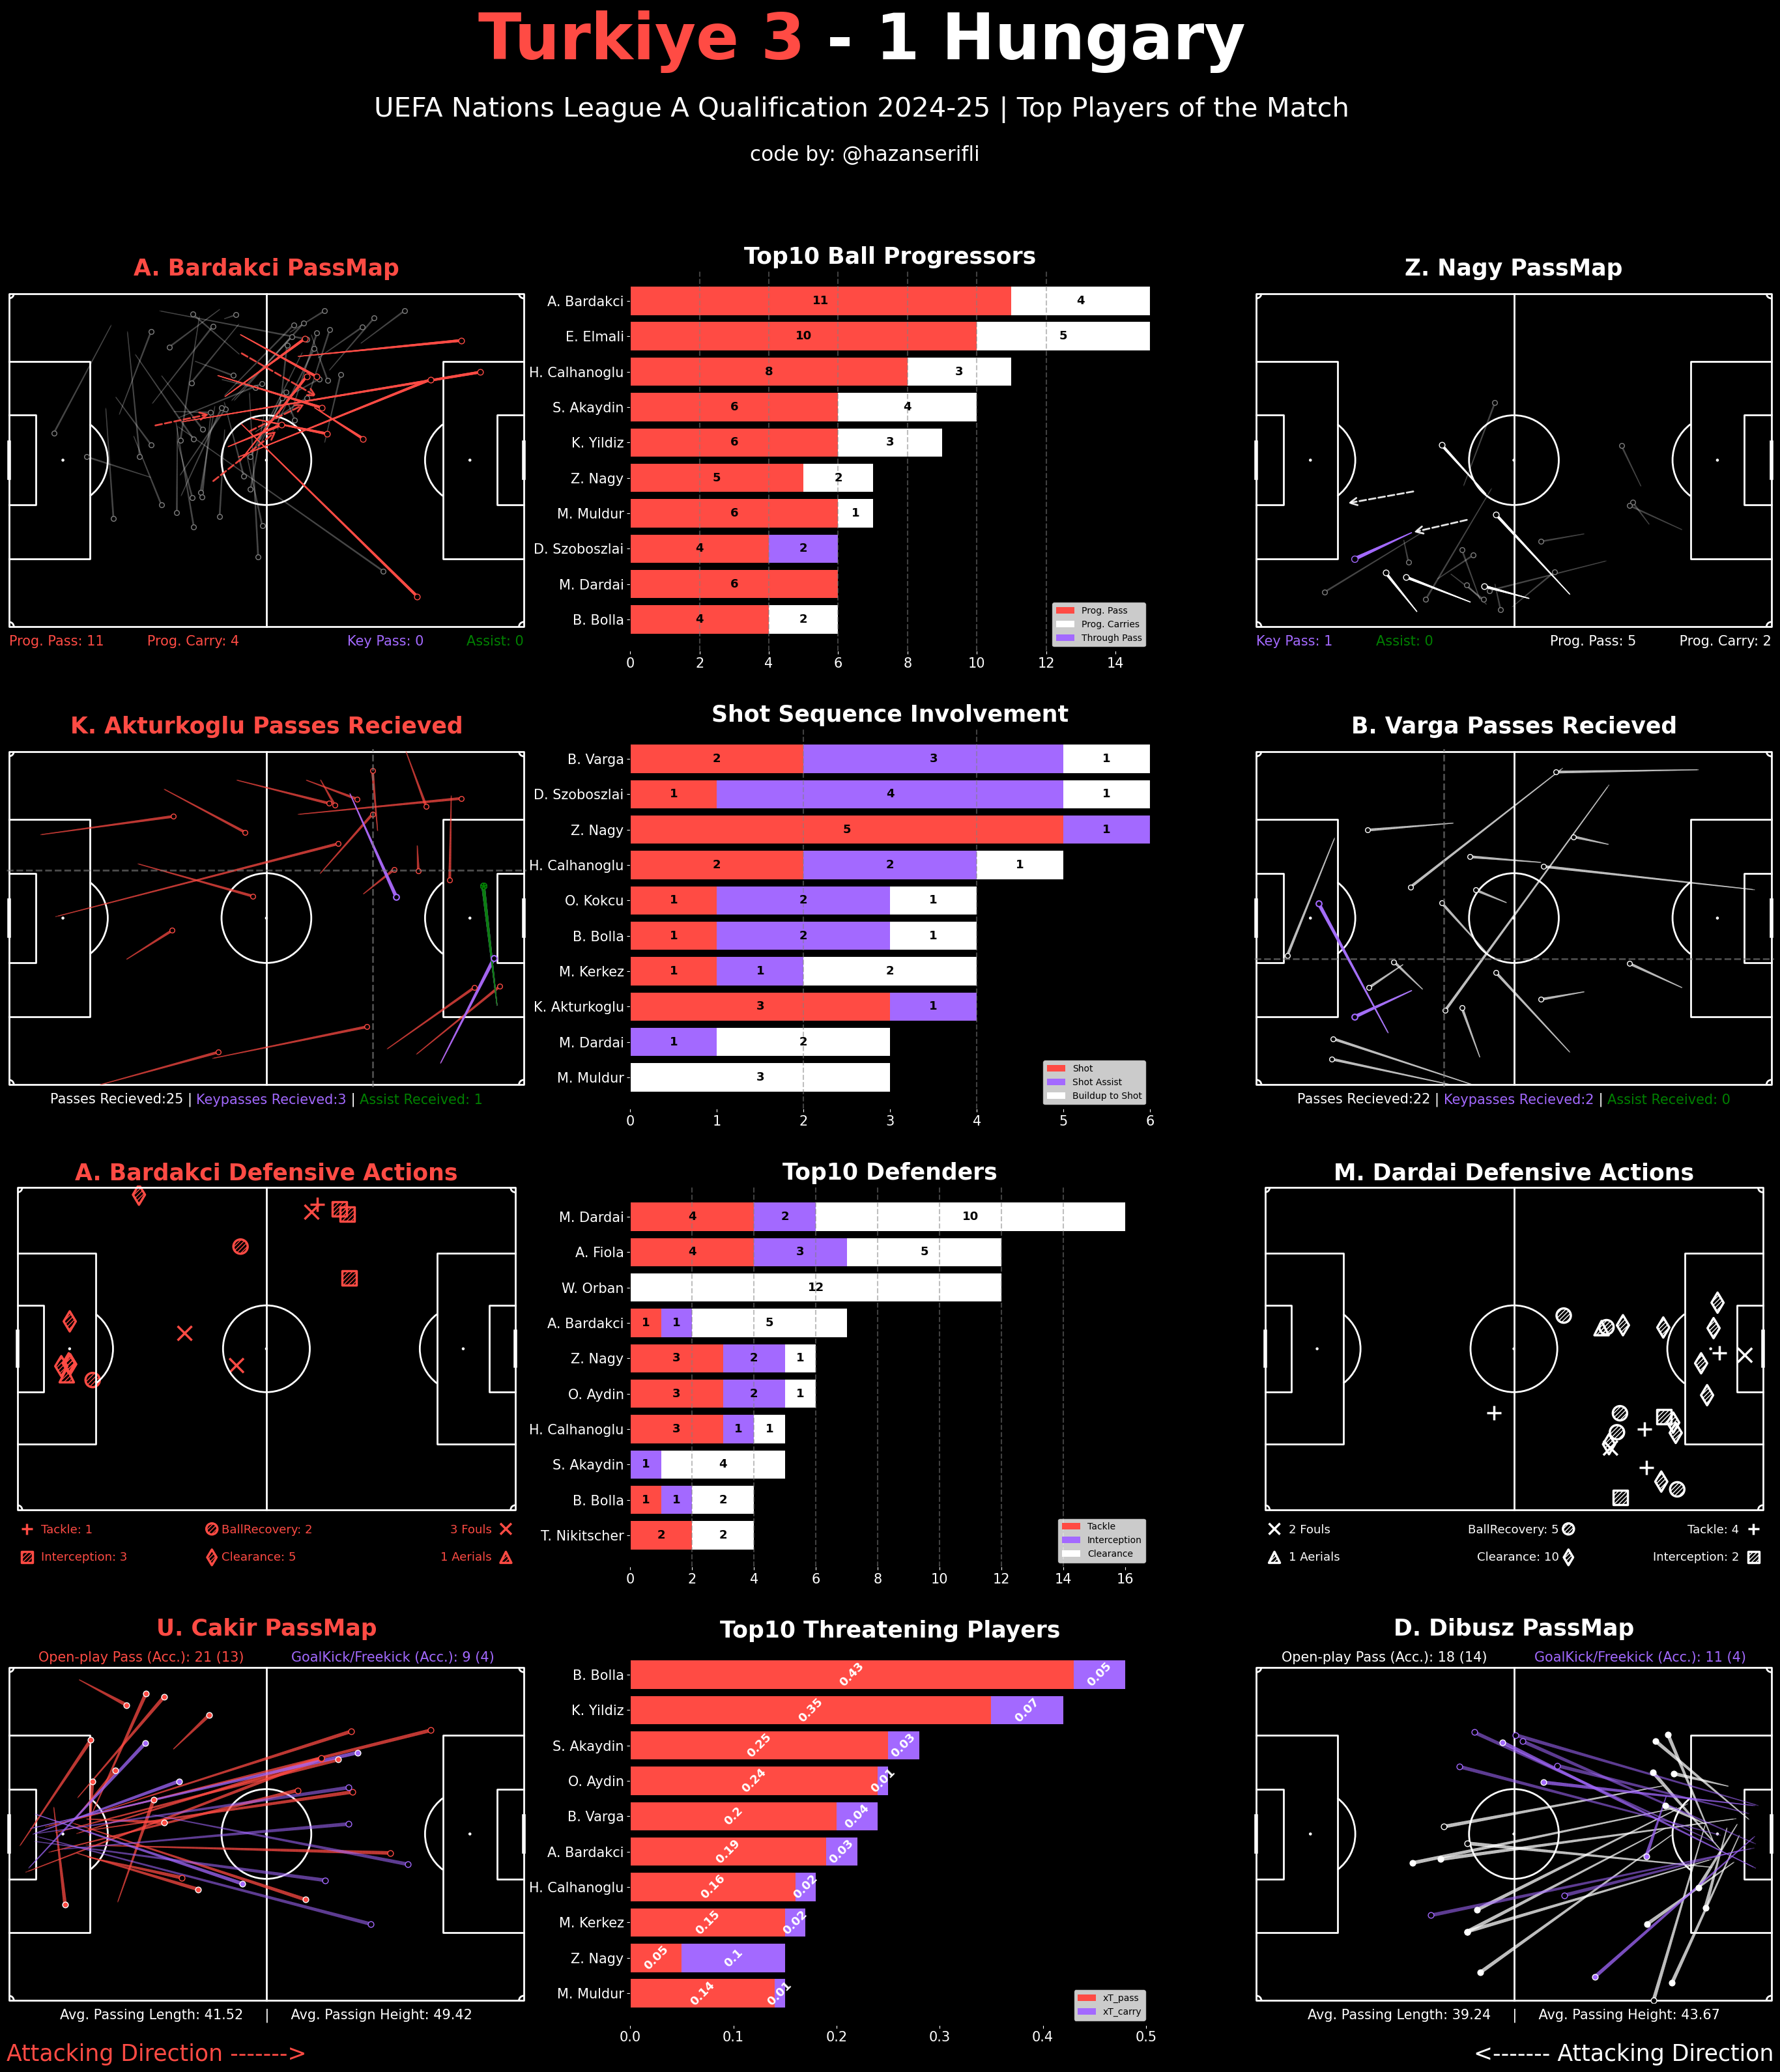

In [51]:
fig, axs = plt.subplots(4,3, figsize=(35,35), facecolor=bg_color)

home_player_passmap(axs[0,0])
passer_bar(axs[0,1])
away_player_passmap(axs[0,2])
home_passes_recieved(axs[1,0])
sh_sq_bar(axs[1,1])
away_passes_recieved(axs[1,2])
home_player_def_acts(axs[2,0])
defender_bar(axs[2,1])
away_player_def_acts(axs[2,2])
home_gk(axs[3,0])
threat_creators(axs[3,1])
away_gk(axs[3,2])

# Headings
highlight_text = [{'color':hcol}, {'color':acol}]
fig_text(0.5, 0.98, f"<{hteamName} {hgoal_count}> - <{agoal_count} {ateamName}>", color=line_color, fontsize=70, fontweight='bold',
            highlight_textprops=highlight_text, ha='center', va='center', ax=fig)

# Subtitles
fig.text(0.5, 0.95, f"UEFA Nations League A Qualification 2024-25 | Top Players of the Match", color=line_color, fontsize=30, ha='center', va='center')
fig.text(0.5, 0.93, f" code by: @hazanserifli", color=line_color, fontsize=22.5, ha='center', va='center')

fig.text(0.125,0.097, 'Attacking Direction ------->', color=hcol, fontsize=25, ha='left', va='center')
fig.text(0.9,0.097, '<------- Attacking Direction', color=acol, fontsize=25, ha='right', va='center')


